In [1]:
# %pip install pyaudio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
from synchronisation import *
import pyaudio
import time



/Users/maxiyengar/Documents/GF3/GF3/channel_estimation_chirp.py:63: SyntaxWarning: invalid escape sequence '\s'
  check = pd.read_csv('Initial_Tests\sine4k_timedata.csv', header=None).to_numpy()


In [2]:
def generate_sound(samples, volume, fs): # volume range [0.0, 1.0]

    p = pyaudio.PyAudio()
    time.sleep(1)

    output_bytes = (volume * samples).tobytes()

    # for paFloat32 sample values must be in range [-1.0, 1.0]
    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=fs,
                    output=True)

    # play. May repeat with different volume values (if done interactively)
    start_time = time.time()
    stream.write(output_bytes)
    print("Played sound for {:.2f} seconds".format(time.time() - start_time))

    stream.stop_stream()
    stream.close()

    p.terminate()

In [3]:
with open('transmitter/data_file.txt', 'r') as file:
    data = file.read().replace('\n', '')
    #data = data.replace(' ', '')
    #data = data.replace('.', '')

print(data)
print(type(bytearray(data, 'ascii')))

data_in_binary = ''
data_in_binary += (''.join(format(ord(x), 'b').zfill(8) for x in data))
data_in_binary += ''.join(str(x) for x in ([0] * (1022 - len(data_in_binary) % 1022)))
data_in_binary = np.array(list(data_in_binary))

np.savetxt("bee_data.txt", data_in_binary, delimiter="", fmt='%s')
print(data_in_binary)
print(len(data_in_binary))
gray_mapping = np.split(data_in_binary, len(data_in_binary)/2)
#print(gray_mapping)
constelatons = []
for index, x in enumerate(gray_mapping):
    if index == 0:
        print(x)
        assert (x == ['0', '1']).all()
    
    if (x == ['0', '0']).all():
        gray_mapping[index] = (1 + 1j)/np.sqrt(2)
        constelatons.append('A')
    if (x == ['0', '1']).all():
        gray_mapping[index] = (-1 + 1j)/np.sqrt(2)
        constelatons.append('B')
        #print((-1 + 1j)/np.sqrt(2))
    if (x == ['1', '1']).all():
        gray_mapping[index] = (-1 - 1j)/np.sqrt(2)
        constelatons.append('C')
    if (x == ['1', '0']).all():
        gray_mapping[index] = (1 - 1j)/np.sqrt(2)
        constelatons.append('D')

np.savetxt("constelations.txt", constelatons, delimiter="", fmt='%s')
    



print(np.array(gray_mapping))
print(len(gray_mapping))
print(len(data_in_binary))
symbol = np.split(np.array(gray_mapping), len(gray_mapping)/511)


for index, x in enumerate(symbol):
    x = np.reshape(x, 511)
    #x = np.pad(x, (1000, 0), "constant", constant_values=(1, 1))
    conj = np.conjugate(x)[::-1]
    symbol[index] = np.concatenate((x, conj), axis=None)
    symbol[index] = np.insert(symbol[index], 0, 0)
    symbol[index] = np.insert(symbol[index], 512, 0)

print(len(symbol[0]))
print(symbol[0])
info = np.fft.ifft(symbol) # should I iDFT the whole block or iDFT each 1024 symbol, is there a difference?
output = open("info.txt", "w")
df = pd.DataFrame(info[0])
df.to_csv("info.csv", header=False, index=False)

print(info.shape)
to_transmit = np.zeros(shape=(len(info), 1056))

for index, x in enumerate(info):
    cyclic_prefix = x[-32:]
    new_x = np.concatenate((cyclic_prefix, x), axis = None)
    to_transmit[index] = new_x

to_transmit = to_transmit[0:5]
for i in range(5):
    to_transmit[i] = to_transmit[i] / np.max(np.abs(to_transmit[i]))

to_transmit = np.concatenate(to_transmit, axis=None)
print(to_transmit.shape)

According to all known laws of aviation, there is no way a bee should be able to fly.Its wings are too small to get its fat little body off the ground.The bee, of course, flies anyway because bees don't care what humans think is impossible.Yellow, black. Yellow, black. Yellow, black. Yellow, black.Ooh, black and yellow!Let's shake it up a little.Barry! Breakfast is ready!Coming!Hang on a second.Hello?Barry?Adam?Can you believe this is happening?I can't.I'll pick you up.Looking sharp.Use the stairs, Your father paid good money for those.Sorry. I'm excited.Here's the graduate.We're very proud of you, son.A perfect report card, all B's.Very proud.Ma! I got a thing going here.You got lint on your fuzz.Ow! That's me!Wave to us! We'll be in row 118,000.Bye!Barry, I told you, stop flying in the house!Hey, Adam.Hey, Barry.Is that fuzz gel?A little. Special day, graduation.Never thought I'd make it.Three days grade school, three days high school.Those were awkward.Three days college. I'm glad I

/var/folders/10/m2d64f1s1kx01s59h9vnf84w0000gn/T/ipykernel_66066/684408873.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
  to_transmit[index] = new_x


In [4]:
fs = 44100
chirp_time = 5
t = np.linspace(0, chirp_time, fs*chirp_time)
f_0 = 1000
f_1 = 16000
chirp = signal.chirp(t, f0=f_0, f1=f_1, t1=chirp_time, method='linear')
chirp = chirp / np.max(np.abs(chirp)) * 0.05

symbol = []
for i in range(511):
    if i <100:
        symbol.append(1+1j)
    elif 100<i<200:
        symbol.append(-1+1j)
    elif 300<i<400:
        symbol.append(1-1j)
    else:
        symbol.append(-1-1j)


"""symbol = np.array(symbol)
conj_symbol = np.conj(symbol)[::-1]
symbol = np.concatenate((symbol, conj_symbol))
symbol = np.insert(symbol, 0, 0)
symbol = np.insert(symbol, 512, 0)
print(symbol.shape)
time_symbol = np.fft.ifft(symbol)
plt.plot(time_symbol)
plt.show()
print(time_symbol.shape)
time_symbol = np.real(time_symbol)
time_symbol = time_symbol / np.max(np.abs(time_symbol))
cyclic = np.concatenate((time_symbol[-32:], time_symbol))

symbol_data = []
for i in range(511):
    if i % 4 == 3:
        symbol_data.append(1+1j)
    elif i % 4 == 2:
        symbol_data.append(-1+1j)
    elif i % 4 == 1:
        symbol_data.append(1-1j)
    elif i % 4 == 0:
        symbol_data.append(-1-1j)

symbol_data = np.array(symbol_data)
conj_symbol_data = np.conj(symbol_data)[::-1]
symbol_data = np.concatenate((symbol_data, conj_symbol_data))
symbol_data = np.insert(symbol_data, 0, 0)
symbol_data = np.insert(symbol_data, 512, 0)
print(symbol_data.shape)
time_symbol_data = np.fft.ifft(symbol_data)
print(time_symbol_data.shape)
time_symbol_data = np.real(time_symbol_data)
time_symbol_data = time_symbol_data / np.max(np.abs(time_symbol_data))
cyclic_data = np.concatenate((time_symbol_data[-32:], time_symbol_data))
print(cyclic_data.shape)"""

'symbol = np.array(symbol)\nconj_symbol = np.conj(symbol)[::-1]\nsymbol = np.concatenate((symbol, conj_symbol))\nsymbol = np.insert(symbol, 0, 0)\nsymbol = np.insert(symbol, 512, 0)\nprint(symbol.shape)\ntime_symbol = np.fft.ifft(symbol)\nplt.plot(time_symbol)\nplt.show()\nprint(time_symbol.shape)\ntime_symbol = np.real(time_symbol)\ntime_symbol = time_symbol / np.max(np.abs(time_symbol))\ncyclic = np.concatenate((time_symbol[-32:], time_symbol))\n\nsymbol_data = []\nfor i in range(511):\n    if i % 4 == 3:\n        symbol_data.append(1+1j)\n    elif i % 4 == 2:\n        symbol_data.append(-1+1j)\n    elif i % 4 == 1:\n        symbol_data.append(1-1j)\n    elif i % 4 == 0:\n        symbol_data.append(-1-1j)\n\nsymbol_data = np.array(symbol_data)\nconj_symbol_data = np.conj(symbol_data)[::-1]\nsymbol_data = np.concatenate((symbol_data, conj_symbol_data))\nsymbol_data = np.insert(symbol_data, 0, 0)\nsymbol_data = np.insert(symbol_data, 512, 0)\nprint(symbol_data.shape)\ntime_symbol_data 

In [5]:
to_transmit = np.concatenate((chirp, to_transmit), axis=None)
to_transmit = to_transmit.astype(np.float32)
print(to_transmit.shape)
print(np.max(np.abs(to_transmit)))


(225780,)
1.0


In [6]:
generate_sound(to_transmit, 1, fs)

Played sound for 5.12 seconds


In [7]:
#Signal Import
data = pd.read_csv('data.txt').to_numpy()
data = np.reshape(data, len(data)) 
y = data

224691


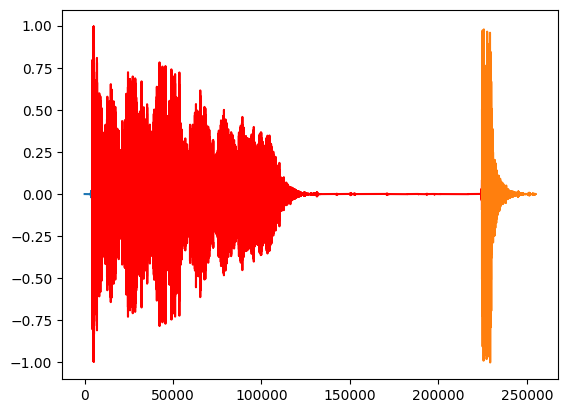

In [8]:
#Synchronization
chirp_time = 5
fs = 44100
t = np.linspace(0, chirp_time, fs*chirp_time)
f_0 = 1000
f_1 = 16000
chirp = signal.chirp(t, f0=f_0, f1=f_1, t1=chirp_time, method='linear')
max_index, cross_correlation, lags = matched_filter_synchronisation(y,chirp, 10, fs)
print(max_index)

#Plot
x = np.linspace(0, len(y), len(y))
plt.plot(x[:lags[max_index]],y[:lags[max_index]])
plt.plot(x[lags[max_index]:lags[max_index] + len(chirp)],y[lags[max_index]:lags[max_index] + len(chirp)], color = 'red')
plt.plot(x[lags[max_index] + len(chirp):], y[lags[max_index] + len(chirp):])
plt.show()


/Users/maxiyengar/Documents/GF3/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/maxiyengar/Documents/GF3/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


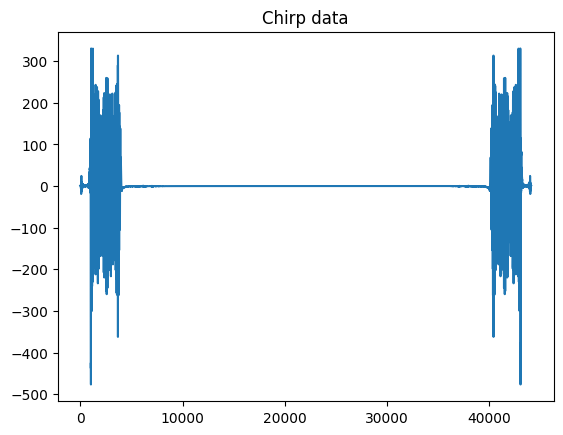

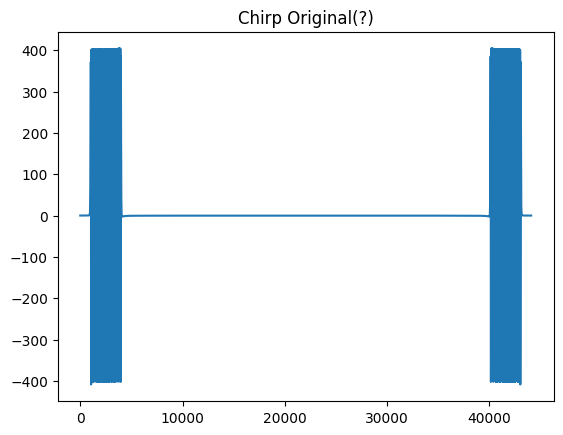

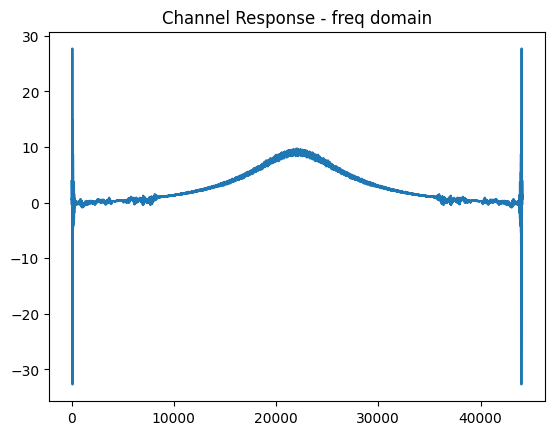

[-0.00604179-2.19327885e-14j -0.01209055+1.40754828e-14j
 -0.01673703+2.48091116e-16j  0.01258094-1.71710754e-14j
 -0.89932371+2.81091931e-14j]


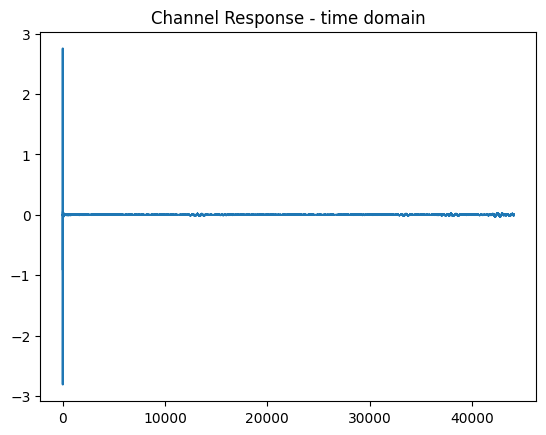

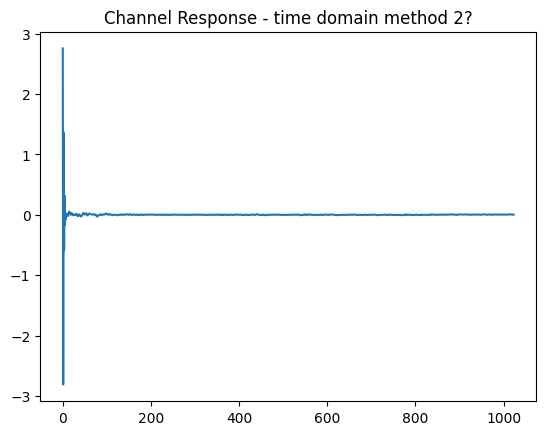

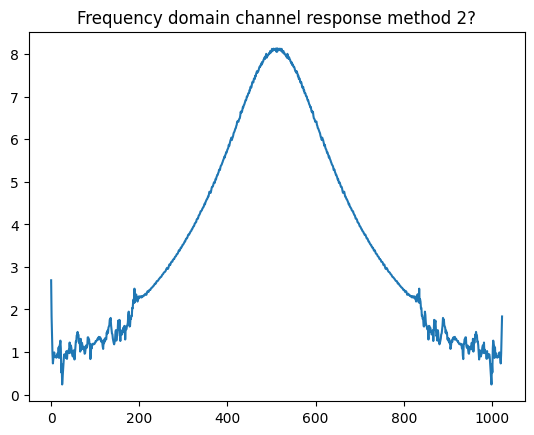

In [10]:
# Channel estimation using the chirp
chirp_data = y[lags[max_index]:lags[max_index] + len(chirp)]
channel_chirp = standered_estimation(chirp, chirp_data, fs)

plt.plot(np.fft.fft(chirp_data, n = 44100))
plt.title("Chirp data")
plt.show()

plt.plot(np.fft.fft(chirp, n = 44100))
plt.title("Chirp Original(?)")
plt.show()

channel_freq = np.fft.fft(chirp_data, n = 44100)/np.fft.fft(chirp, n = 44100)
channel_time = np.fft.ifft(channel_freq, n = 44100)

plt.plot(channel_freq)
plt.title("Channel Response - freq domain")
plt.show()
print(channel_time[-5:])
channel_time = np.roll(channel_time, 1)
plt.plot(channel_time)
plt.title("Channel Response - time domain")
plt.show()


# plt.plot(channel_chirp) ... - I think this is the same as channel_freq?
# plt.show()

time_channel_chirp = np.fft.ifft(channel_chirp)
time_channel_chirp = np.real(time_channel_chirp)
time_channel_chirp = time_channel_chirp[:1024]
plt.plot(time_channel_chirp)
plt.title("Channel Response - time domain method 2?")
plt.show()
chanel_estimation = np.fft.fft(time_channel_chirp, n=1024)
plt.plot(np.abs(chanel_estimation))
plt.title("Frequency domain channel response method 2?")
plt.show()

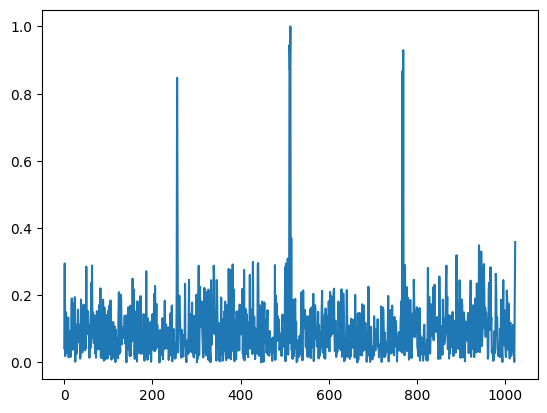

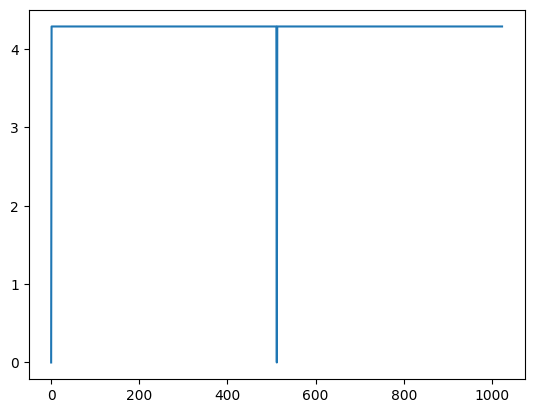

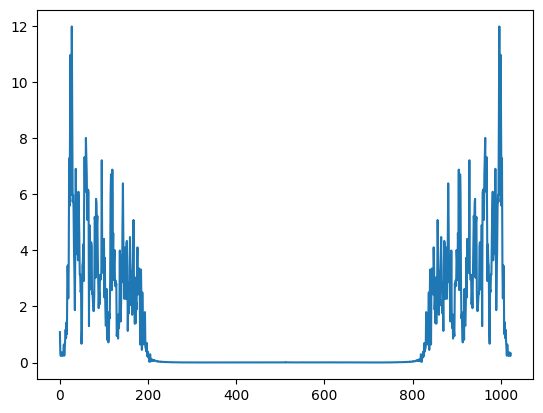

[-0.14667022-1.38777878e-17j -0.05013273-1.66967135e-17j
  0.25993805-1.73472348e-18j ...  0.10803416-1.02999206e-17j
  0.09260762+8.89045781e-18j -0.04204584-3.03576608e-18j]


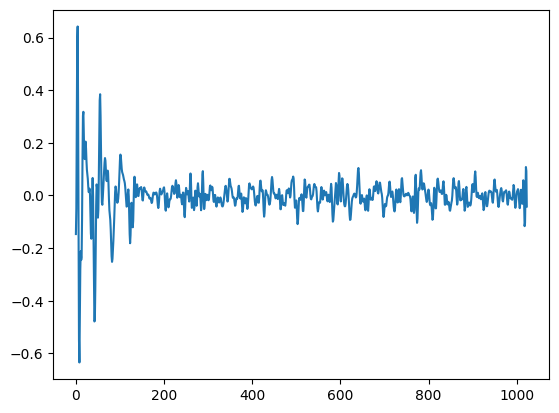

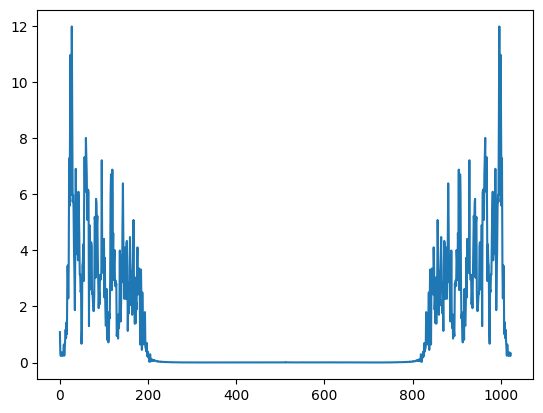

In [153]:
# Channel estimation Using OFDM
n = 1056
#OFDM_DATA = pd.read_csv('OFDM_DATA.csv').to_numpy()
OFDM_DATA = to_transmit[len(chirp) +32: len(chirp) + 1056]
plt.plot(np.abs(OFDM_DATA))
plt.show()
plt.plot(np.abs(np.fft.fft(OFDM_DATA)))
plt.show()
Start_index = lags[max_index] + len(chirp)

# Channel estimation
Symbol_One = y[Start_index:Start_index + n]

Symbol_One = Symbol_One[32:]
OFDM_DATA[0] = 1
OFDM_DATA[512] = 1
chanel_estimation_2 = standered_estimation(OFDM_DATA, Symbol_One, 1024)
plt.plot(np.abs(chanel_estimation_2))
plt.show()
time_channel_2 = np.fft.ifft(chanel_estimation_2)
"""time_channel_2 = time_channel_2[200:]
time_channel_2 = np.pad(time_channel_2, (0, 824), "constant", constant_values=(0, 0))""" #TO BE DONE -  FIR TIME TO BE EXPANDED
chanel_estimation_2 = np.fft.fft(time_channel_2, n=1024)
print(time_channel_2)
plt.plot((time_channel_2))
plt.show()
plt.plot(np.abs(chanel_estimation_2))
plt.show()


220500
221556
224692
(1024,)
[-0.60308   +0.j         -0.60331697-0.0497544j  -0.53822137-0.05212574j
 ... -0.59679514+0.16317618j -0.53822137+0.05212574j
 -0.60331697+0.0497544j ]
[2.68570783+0.j         1.82791032-0.16238054j 1.39805834+0.2127206j  ...
 0.91124812-0.31303169j 1.39805834-0.2127206j  1.82791032+0.16238054j]
(1024,)


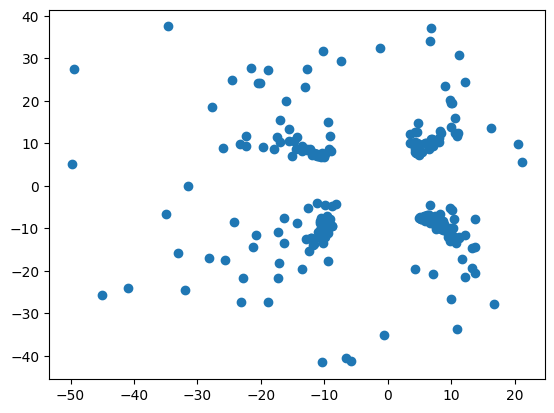

In [160]:
Start_index = lags[max_index] + len(chirp)
print(len(chirp))
print(len(chirp) + 1056)
print(Start_index)
n = 1056
Symbol_Two = y[Start_index + 1*n :Start_index + 2*n]
Symbol_Two = Symbol_Two[32:]
print(Symbol_Two.shape)
Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
print(Symbol_Two)
print(chanel_estimation)
print(chanel_estimation.shape)
Symbol_Two_correct = Symbol_Two / chanel_estimation
Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2



plt.scatter(np.real(Symbol_Two_correct_2[250:511]), np.imag(Symbol_Two_correct_2[250:511]))


In [249]:
with open('transmitter/data_file.txt', 'r') as file:
    data = file.read().replace('\n', '')
    #data = data.replace(' ', '')
    #data = data.replace('.', '')

print(data)
print(type(bytearray(data, 'ascii')))

data_in_binary = ''
data_in_binary += (''.join(format(ord(x), 'b').zfill(8) for x in data))
data_in_binary += ''.join(str(x) for x in ([0] * (1022 - len(data_in_binary) % 1022)))
data_in_binary = np.array(list(data_in_binary))

np.savetxt("bee_data.txt", data_in_binary, delimiter="", fmt='%s')
print(data_in_binary)
print(len(data_in_binary))
gray_mapping = np.split(data_in_binary, len(data_in_binary)/2)
#print(gray_mapping)
constelatons = []
for index, x in enumerate(gray_mapping):
    if index == 0:
        print(x)
        assert (x == ['0', '1']).all()
    
    if (x == ['0', '0']).all():
        gray_mapping[index] = (1 + 1j)/np.sqrt(2)
        constelatons.append('A')
    if (x == ['0', '1']).all():
        gray_mapping[index] = (-1 + 1j)/np.sqrt(2)
        constelatons.append('B')
        #print((-1 + 1j)/np.sqrt(2))
    if (x == ['1', '1']).all():
        gray_mapping[index] = (-1 - 1j)/np.sqrt(2)
        constelatons.append('C')
    if (x == ['1', '0']).all():
        gray_mapping[index] = (1 - 1j)/np.sqrt(2)
        constelatons.append('D')

np.savetxt("constelations.txt", constelatons, delimiter="", fmt='%s')
    



print(np.array(gray_mapping))
print(len(gray_mapping))
print(len(data_in_binary))
symbol = np.split(np.array(gray_mapping), len(gray_mapping)/511)


for index, x in enumerate(symbol):
    x = np.reshape(x, 511)
    #x = np.pad(x, (1000, 0), "constant", constant_values=(1, 1))
    conj = np.conjugate(x)[::-1]
    symbol[index] = np.concatenate((x, conj), axis=None)
    symbol[index] = np.insert(symbol[index], 0, 0)
    symbol[index] = np.insert(symbol[index], 512, 0)

print(len(symbol[0]))
print(symbol[0])
info = np.fft.ifft(symbol) # should I iDFT the whole block or iDFT each 1024 symbol, is there a difference?
output = open("info.txt", "w")
df = pd.DataFrame(info[0])
df.to_csv("info.csv", header=False, index=False)

print(info.shape)
to_transmit_2 = np.zeros(shape=(len(info), 1056))

for index, x in enumerate(info):
    cyclic_prefix = x[-32:]
    new_x = np.concatenate((cyclic_prefix, x), axis = None)
    to_transmit_2[index] = new_x

for i in range(len(to_transmit_2)):
    to_transmit_2[i] = to_transmit_2[i] / np.max(np.abs(to_transmit_2[i]))

to_transmit_2 = np.concatenate(to_transmit_2, axis=None)
print(to_transmit_2.shape)

According to all known laws of aviation, there is no way a bee should be able to fly.Its wings are too small to get its fat little body off the ground.The bee, of course, flies anyway because bees don't care what humans think is impossible.Yellow, black. Yellow, black. Yellow, black. Yellow, black.Ooh, black and yellow!Let's shake it up a little.Barry! Breakfast is ready!Coming!Hang on a second.Hello?Barry?Adam?Can you believe this is happening?I can't.I'll pick you up.Looking sharp.Use the stairs, Your father paid good money for those.Sorry. I'm excited.Here's the graduate.We're very proud of you, son.A perfect report card, all B's.Very proud.Ma! I got a thing going here.You got lint on your fuzz.Ow! That's me!Wave to us! We'll be in row 118,000.Bye!Barry, I told you, stop flying in the house!Hey, Adam.Hey, Barry.Is that fuzz gel?A little. Special day, graduation.Never thought I'd make it.Three days grade school, three days high school.Those were awkward.Three days college. I'm glad I

C:\Users\kmc07\AppData\Local\Temp\ipykernel_37560\3168893700.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
  to_transmit_2[index] = new_x


In [250]:
fs = 44100
chirp_time = 5
t = np.linspace(0, chirp_time, fs*chirp_time)
f_0 = 1000
f_1 = 22000
chirp = signal.chirp(t, f0=f_0, f1=f_1, t1=chirp_time, method='linear')
chirp = chirp / np.max(np.abs(chirp)) * 0.05
chirp = chirp.astype(np.float32)
one_second = np.zeros(44100)
transmit = np.concatenate((chirp, one_second, to_transmit_2), axis=None)
transmit = transmit.astype(np.float32)
print(transmit.shape)

(662712,)


In [251]:
generate_sound(transmit, 1, fs)

Played sound for 15.06 seconds


In [198]:
#Signal Import
data = pd.read_csv('data2.txt').to_numpy()
data = np.reshape(data, len(data)) 
y = data
print(y.shape)

(629759,)


223664


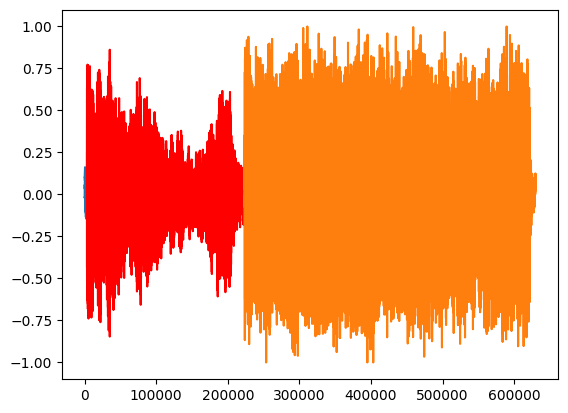

In [199]:
#Synchronization
chirp_time = 5
fs = 44100
t = np.linspace(0, chirp_time, fs*chirp_time)
f_0 = 1000
f_1 = 22000
chirp = signal.chirp(t, f0=f_0, f1=f_1, t1=chirp_time, method='linear')
max_index, cross_correlation, lags = matched_filter_synchronisation(y,chirp, 10, fs)
print(max_index)

#Plot
x = np.linspace(0, len(y), len(y))
plt.plot(x[:lags[max_index]],y[:lags[max_index]])
plt.plot(x[lags[max_index]:lags[max_index] + len(chirp)],y[lags[max_index]:lags[max_index] + len(chirp)], color = 'red')
plt.plot(x[lags[max_index] + len(chirp):], y[lags[max_index] + len(chirp):])
plt.show()

c:\Users\kmc07\OneDrive\Desktop\GF3_2\GF3\.venv\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\kmc07\OneDrive\Desktop\GF3_2\GF3\.venv\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


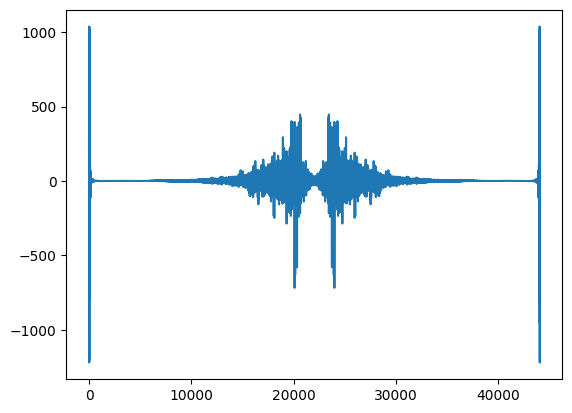

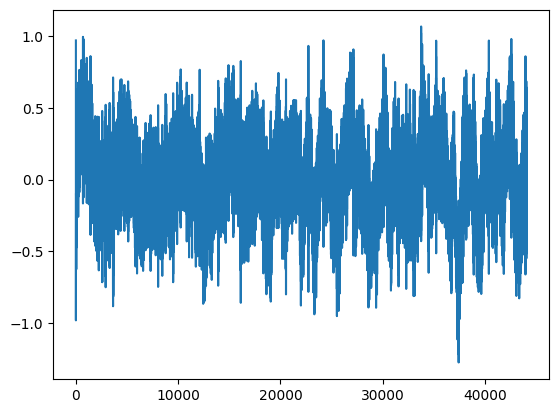

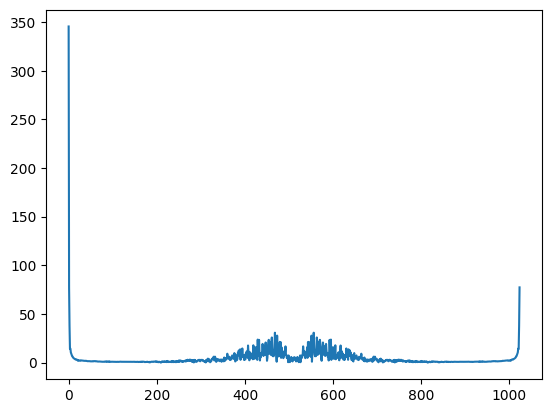

In [200]:
# Channel estimation using the chirp
chirp_data = y[lags[max_index]:lags[max_index] + len(chirp)]
channel_chirp = standered_estimation(chirp, chirp_data, fs)

plt.plot(channel_chirp)
plt.show()
channel_time = np.fft.ifft(channel_chirp)
plt.plot(channel_time)
plt.show()

channel_time = channel_time[:1024]
channel_freq = np.fft.fft(channel_time, n = 1024)
plt.plot(np.abs(channel_freq))

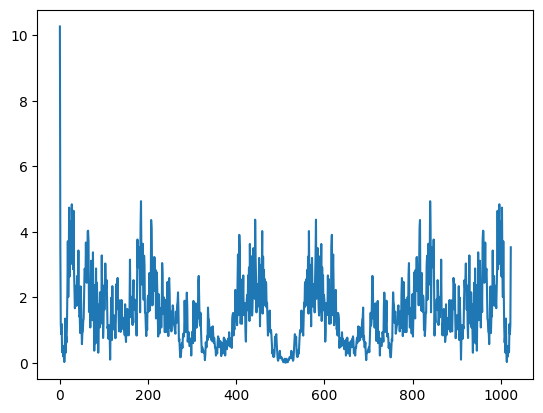

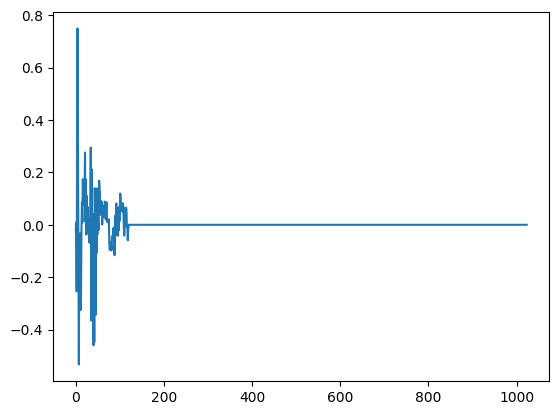

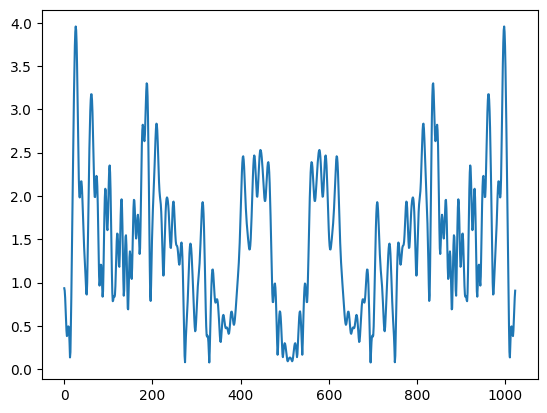

In [230]:
# Channel estimation Using OFDM
n = 1056
#OFDM_DATA = pd.read_csv('OFDM_DATA.csv').to_numpy()
OFDM_DATA = to_transmit_2[32: 1056]

Start_index = lags[max_index] + len(chirp)

# Channel estimation
Symbol_One = y[Start_index:Start_index + n]

Symbol_One = Symbol_One[32:]
OFDM_DATA[0] = 1
OFDM_DATA[512] = 1
chanel_estimation_2 = standered_estimation(OFDM_DATA, Symbol_One, 1024)
plt.plot(np.abs(chanel_estimation_2))
plt.show()
time_channel_2 = np.fft.ifft(chanel_estimation_2, n=1024)
filter = 120
time_channel_2 = time_channel_2[:filter]
time_channel_2 = np.pad(time_channel_2, (0, 1024 - filter), "constant", constant_values=(0, 0)) #TO BE DONE -  FIR TIME TO BE EXPANDED
chanel_estimation_2 = np.fft.fft(time_channel_2, n=1024)
plt.plot((time_channel_2))
plt.show()
plt.plot(np.abs(chanel_estimation_2))
plt.show()

220500
221556
223665
[ 0.14026  0.06989  0.33505 ... -0.11063  0.07236  0.20709]
(1024,)
[-5.01656   +0.j         13.44882488-5.48070429j  2.38119104+1.32748013j
 ...  1.19433996+0.05452357j  2.38119104-1.32748013j
 13.44882488+5.48070429j]
[345.5172003  +0.j         -55.14277722+54.13030145j
  -3.0753622 +37.57754546j ...  -7.68931033-11.74857791j
  -3.0753622 -37.57754546j -55.14277722-54.13030145j]
(1024,)


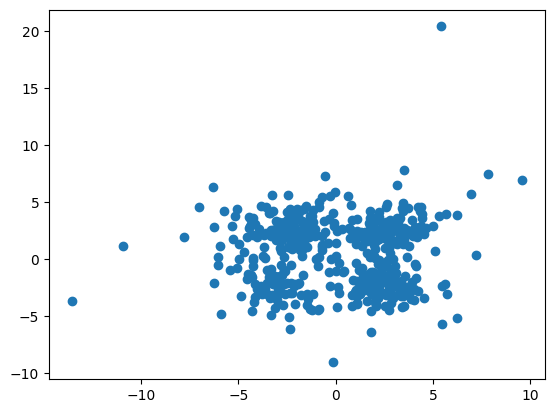

In [247]:
Start_index = lags[max_index] + len(chirp)
print(len(chirp))
print(len(chirp) + 1056)
print(Start_index)
n = 1056
index = 2
Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
print(Symbol_Two)
Symbol_Two = Symbol_Two[32:]
print(Symbol_Two.shape)
Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
print(Symbol_Two)
print(chanel_estimation)
print(chanel_estimation.shape)
Symbol_Two_correct = Symbol_Two / chanel_estimation
Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2




plt.scatter(np.real(Symbol_Two_correct_2[30:511]), np.imag(Symbol_Two_correct_2[30:511]))